<a href="https://colab.research.google.com/github/louisechilds/ADS2002-Catheter/blob/main/Catheter_project_Balancing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Catheter project (Balancing)

Contributors:
Adam Choong
Louise Childs
Isaac Woods
Fengzhe Yang


In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
import pandas as pd
RS=42#set random seed consistent
train=pd.read_csv('/content/drive/MyDrive/ADS2002/ranzcr-clip-catheter-line-classification/train.csv')
train_annot=pd.read_csv('/content/drive/MyDrive/ADS2002/ranzcr-clip-catheter-line-classification/train_annotations.csv')

## EDA and prelimary inspection
We must spot any missing values and decide what to do with them if we find them. Next we do some research on definitions for our variables and generate visual representations of our data

In [82]:
train.isna().sum(),train_annot.isna().sum()

(StudyInstanceUID              0
 ETT - Abnormal                0
 ETT - Borderline              0
 ETT - Normal                  0
 NGT - Abnormal                0
 NGT - Borderline              0
 NGT - Incompletely Imaged     0
 NGT - Normal                  0
 CVC - Abnormal                0
 CVC - Borderline              0
 CVC - Normal                  0
 Swan Ganz Catheter Present    0
 PatientID                     0
 dtype: int64,
 StudyInstanceUID    0
 label               0
 data                0
 dtype: int64)

There are no missing values to impute in the training dataset. Now we complete standard exploratory data analysis and visualisation on the csv files:

In [83]:
total_pats=train['PatientID'].unique().shape[0]
print(f"There are {train['PatientID'].unique().shape[0]} patients being examined in the data")

There are 3255 patients being examined in the data


In [84]:
#group data by patients
patients=train.groupby(['PatientID']).sum()
patients.head()

<ipython-input-84-9639944617e7>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  patients=train.groupby(['PatientID']).sum()


,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
PatientID,,,,,,,,,,,
003e65ddb,0,0,0,0,0,0,0,2,0,1,0
00757839e,0,0,0,0,0,0,0,0,2,2,0
008d12164,0,3,1,0,0,3,6,2,6,7,0
009cedf2b,0,0,0,0,0,0,0,0,1,2,0
009de0875,0,0,0,0,0,0,0,0,0,9,0


Features and terms in the dataset

* `ETT`: Endotrachael position describes the placement of the tube into the trachea that enables artificial ventilation. (assists with breathing)
* `NGT`: Nasogastric tube positioning describes the placement of the tube through the nostril to the back of the throat and passing through the oesophagus to the stomach. The nasogastric tube assists with feeding food into the digestive system.
* `CVC`: central venous catheater tube placement describes how the tube has been inserted into the heart through the inferior vena cava (a large vein). The purpose of the CVC tube is to pump drugs into circulation around the body.
* Swam Ganz Catheter: a thin tube that passes through the arteries in the heart to the lungs. This tube monitors the heart's blood flow and pressure.

In [85]:
print(f"The are {train['StudyInstanceUID'].unique().shape[0]} images")
print(f"The are {train_annot['StudyInstanceUID'].unique().shape[0]} annotations")

The are 30083 images
The are 9095 annotations


In [86]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

<Axes: title={'center': 'Levels of catheter placement by type'}>

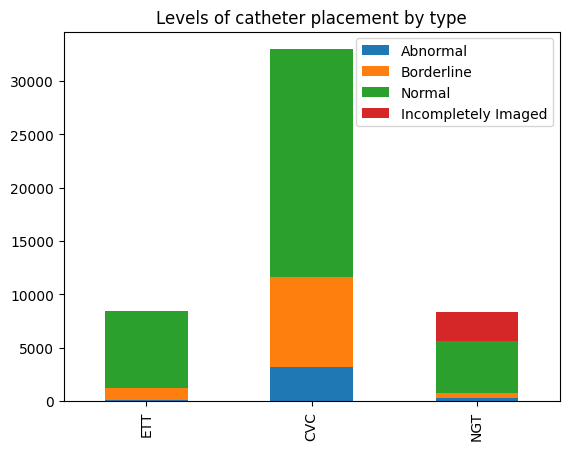

In [87]:
sums=pd.DataFrame(patients.sum())
sums
graph_sums=pd.DataFrame({'ETT':[patients['ETT - Abnormal'].sum(),patients['ETT - Borderline'].sum(),patients['ETT - Normal'].sum(),0],
                         'CVC':[patients['CVC - Abnormal'].sum(),patients['CVC - Borderline'].sum(),patients['CVC - Normal'].sum(),0],
                         'NGT':[patients['NGT - Abnormal'].sum(),patients['NGT - Borderline'].sum(),patients['NGT - Normal'].sum(),patients['NGT - Incompletely Imaged'].sum()]})
graph_sums=graph_sums.transpose()
graph_sums=graph_sums.rename(columns={0:'Abnormal',1:'Borderline',2:'Normal',3:'Incompletely Imaged'})
graph_sums.plot.bar(stacked=True,title='Levels of catheter placement by type')

From this visual, there is an overwhelming presence of normally placed catheters as expected but this creates issues with bias and other imbalanced data related problems.

Our classifiication problem is of a binary nature to simplify the purpose of our investigation. More specifically, we want to detect anolmalies, but we do not want to pay attention to what type, initially. For this reason, we consider removing incompletely imaged instances from our training and testing sets.

Furthermore, we must consider balancing the dataset using different sampling methods. This is to moderate our bias and variance in the data we are testing. This will be done during our sampling stage.

## Reading the data
We need to manipulate our dataset so it fulfils the mentioned criteria
* Binary labelling
* Relevant outcomes only considered
* Well balanced variations

Since the entire dataset is too large and we need to be mindful of the RAM capacity, there needs to be a function in place to partially read a random sample of the dataset. We also need to organise the dataframes in such as way that it contains the images as the "feature variable" and the outcomes as the labels

### Image data preprocessing
Our image data is not quite ready to be pipelined into our model. Thus, these steps will be performed:
* Change the shape of our images to be the same as each other. The standardised distribution will be determined by the most popular dimensions across the data selected.
* Compress into arrays so that PCA (principal component analysis) model can handle the data. We want to use PCA to compress the images for use in other models.
We will be using the ComputerVision cv2 library and PCA to perform these tasks.

In [88]:
#separate by normal or something else for each type of catheter
test_CVC=train[['StudyInstanceUID','CVC - Abnormal','CVC - Normal','CVC - Borderline']]
test_CVC=test_CVC.drop(test_CVC[(test_CVC['CVC - Abnormal'] == 0) & (test_CVC['CVC - Normal'] == 0) & (test_CVC['CVC - Borderline'] == 0)].index)
test_ETT=train[['StudyInstanceUID','ETT - Abnormal','ETT - Normal','ETT - Borderline']]
test_ETT=test_ETT.drop(test_ETT[(test_ETT['ETT - Abnormal'] == 0) & (test_ETT['ETT - Normal'] == 0) & (test_ETT['ETT - Borderline'] == 0)].index)
test_NGT=train[['StudyInstanceUID','NGT - Abnormal','NGT - Normal','NGT - Borderline','NGT - Incompletely Imaged']]
test_NGT=test_NGT.drop(test_NGT[(test_NGT['NGT - Abnormal'] == 0) & (test_NGT['NGT - Normal'] == 0) & (test_NGT['NGT - Borderline'] == 0) & (test_NGT['NGT - Incompletely Imaged']==0)].index)
test_NGT=test_NGT.drop(test_NGT[(test_NGT['NGT - Incompletely Imaged']==1)].index)

In [89]:
import cv2
import os
directory_path='/content/drive/MyDrive/ADS2002/image_collection'

In [90]:
#add array representation of image as the feature variables, acts as a substitute to reading images in bulk
def add_feature(df,folder):
  if 'image' not in df.columns:
    df['image']=''
  for i, row in df.iterrows():
    filename=row['StudyInstanceUID']+'.jpg'
    feature = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE)
    cv2.resize(feature,dsize=(300,300))#resize to manageable dimensions
    df._set_value(i,'image',feature)
  return df

In [91]:
images = os.listdir(directory_path) # list of all the images
n_test_images = int(len(images) * 0.1) # 10% of the total images

subset_images = np.random.choice(images, size=n_test_images, replace=False)

for i in range(len(subset_images)):
  subset_images[i]=subset_images[i].removesuffix('.jpg')
cvc_images_train=test_CVC.loc[train['StudyInstanceUID'].isin(subset_images)]
ngt_images_train=test_NGT.loc[train['StudyInstanceUID'].isin(subset_images)]
ett_images_train=test_ETT.loc[train['StudyInstanceUID'].isin(subset_images)]
cvc=add_feature(cvc_images_train,directory_path)
ngt=add_feature(ngt_images_train,directory_path)
ett=add_feature(ett_images_train,directory_path)
#convert to binary datasets
cvc_binary_test=cvc[['CVC - Normal','StudyInstanceUID','image']]
ngt_binary_test=ngt[['NGT - Normal','StudyInstanceUID','image']]
ett_binary_test=ett[['ETT - Normal','StudyInstanceUID','image']]

<ipython-input-90-43fb40fafbc1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image']=''
<ipython-input-90-43fb40fafbc1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image']=''
<ipython-input-90-43fb40fafbc1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

The results of preprocessing are a label column and a column of array representations of the corresponding image. These arrays act as the feature variables that impact the outcome. As these arrays have high dimensions, they can be compacted using PCA.

### PCA on images
We may need to compress the image data further to pipeline the data to other models too

In [92]:
#Isaac to do PCA here if necessary
#ready to do since preprocessing done now

## Samping and splitting

Firstly, we need to split our training, validation and testing sets. Next we must decide on an effective sampling method. As shown in the visual above, there is a clear bias towards having normal catheters as expected otherwise an overwhelming and unacceptable amount of patients would have catheter-related problems and risks. Of all the sampling techniques, it seems that the most appropriate choices are either random undersampling or Adaptive synthetic sampling because given the nature of our data being image based, we cannot replicate minorities and image instances due to computing capacity purposes and the fact that images are visually unique cannot be treated quite the same as other forms of sample statistics. SMOTE can also be considered since it does not involve replication (ChatGPT)

## Kmeans: unsupervied method for image segmentation
We are ready to apply our first unsupervised machine learning technique; k means. This method will identify segments of the image, which is quite useful for us because we want to identify the areas and regions of interest (i.e catheaters) for our deep learning models to work effectively.

In [93]:
#Isaac to do Kmeans here, include commentary on results
#PCA required first before engaging
cvc_binary_test.dtypes

CVC - Normal         int64
StudyInstanceUID    object
image               object
dtype: object

First we check that the data is in the correct format.

In [94]:
cvc_binary_test

,CVC - Normal,StudyInstanceUID,image
575,1,1.2.826.0.1.3680043.8.498.98868688063682029179...,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
737,1,1.2.826.0.1.3680043.8.498.98311970012797959433...,"[[3, 5, 9, 11, 12, 11, 9, 7, 8, 8, 8, 8, 7, 7,..."
771,1,1.2.826.0.1.3680043.8.498.96954713473231855718...,"[[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,..."
907,1,1.2.826.0.1.3680043.8.498.98610781732941210925...,"[[2, 2, 2, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3,..."
1370,1,1.2.826.0.1.3680043.8.498.97077295886695881642...,"[[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,..."
1470,1,1.2.826.0.1.3680043.8.498.97608411246349275250...,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."
1499,1,1.2.826.0.1.3680043.8.498.98883008008926824052...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2400,0,1.2.826.0.1.3680043.8.498.97576992904366052571...,"[[0, 0, 0, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,..."
2564,1,1.2.826.0.1.3680043.8.498.97065141260424680232...,"[[42, 41, 59, 77, 74, 70, 73, 74, 80, 78, 73, ..."
4491,1,1.2.826.0.1.3680043.8.498.96858232333572510807...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


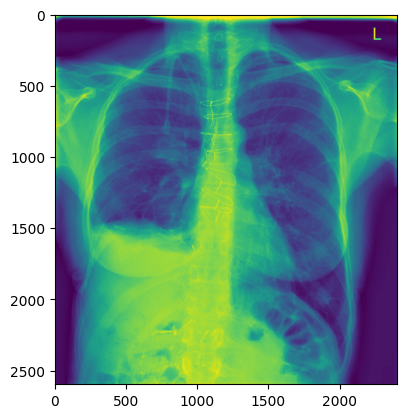

In [95]:
img1 = cvc_binary_test.iloc[0].iat[2]
plt.imshow(img1)

In [96]:
img1.shape

(2597, 2406)

In [97]:
img1

array([[255, 255, 255, ..., 208, 159, 150],
       [255, 255, 255, ..., 208, 159, 150],
       [255, 255, 255, ..., 208, 159, 150],
       ...,
       [ 17,  17,  16, ...,  17,  14,  11],
       [ 17,  17,  16, ...,  17,  14,  11],
       [ 17,  17,  16, ...,  17,  14,  11]], dtype=uint8)

In [98]:
flat = img1.flatten()
flat

array([255, 255, 255, ...,  17,  14,  11], dtype=uint8)

In [99]:
cvc_binary_test.shape[0]

49

In [100]:
shapes = []
for i in range(cvc_binary_test.shape[0]):
  shapes.append(cvc_binary_test.iloc[i].iat[2].shape)

min(shapes)

(2048, 2500)

The image vectors are not all the same shape so we need to change them. I am going to resize them all to the smallest value as this is easiest.

In [101]:
new_cvc_binary = cvc_binary_test.copy()
new_cvc_binary['image'] = new_cvc_binary['image'].apply(lambda x: cv2.resize(x, (2048, 2500)))

In [102]:
for i in range(cvc_binary_test.shape[0]):
  print(new_cvc_binary.iloc[i].iat[2].shape)

(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)


This is good. The image has only two dimensions as we imported it in grayscale getting rid of the third, RGB, dimension as this negatively effects the KMeans models. They are also all the same dimension for the model.

However we need to flatten each of the entries in 'image' right now as they are an array of arrays instead of just one array which KMeans doesn't like.

In [103]:
flat_copy = new_cvc_binary.copy()
flat_copy['image'] = flat_copy['image'].apply(lambda x: np.array(x).flatten())

In [104]:
flat_copy

,CVC - Normal,StudyInstanceUID,image
575,1,1.2.826.0.1.3680043.8.498.98868688063682029179...,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
737,1,1.2.826.0.1.3680043.8.498.98311970012797959433...,"[3, 6, 10, 12, 11, 9, 7, 8, 8, 8, 7, 7, 7, 8, ..."
771,1,1.2.826.0.1.3680043.8.498.96954713473231855718...,"[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, ..."
907,1,1.2.826.0.1.3680043.8.498.98610781732941210925...,"[2, 2, 2, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4, 4, ..."
1370,1,1.2.826.0.1.3680043.8.498.97077295886695881642...,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ..."
1470,1,1.2.826.0.1.3680043.8.498.97608411246349275250...,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
1499,1,1.2.826.0.1.3680043.8.498.98883008008926824052...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2400,0,1.2.826.0.1.3680043.8.498.97576992904366052571...,"[0, 0, 0, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2564,1,1.2.826.0.1.3680043.8.498.97065141260424680232...,"[42, 47, 69, 74, 70, 73, 76, 79, 73, 68, 63, 6..."
4491,1,1.2.826.0.1.3680043.8.498.96858232333572510807...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [105]:
X = np.stack(flat_copy['image'].values)
Y = flat_copy['CVC - Normal']

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Fit the K-Means model on the training data
kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Now we can see how accurate this model is.

In [107]:
from sklearn.metrics import accuracy_score
preds = kmeans.predict(X_test)
print('Accuracy of KMeans is', np.round(accuracy_score(y_test, preds),3))

Accuracy of KMeans is 0.6


This gives an accuracy of 0.75 for our binary classification model which actually isn't too bad for an initial model.

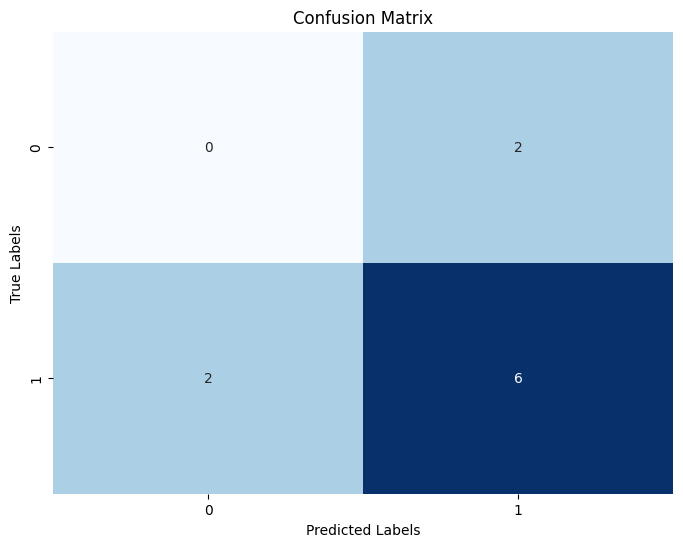

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, preds)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

# Set axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()


We can see that just from this trial it was pretty good at predicting normal catheters accurately but had a little trouble with false negatives, predicting an abnormal catheter when it should have beena normal one.

 ## Balancing the Data

 Data imbalances are solved using SMOTE

Create a baseline model from kMeans analysis
so we have a benchmark for the performance and can investigate improvements after balancing the data

In [109]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue Positives: ', tp)

True negatives:  0 
False positives:  2 
False negatives:  2 
True Positives:  6


In [110]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.75      0.75      0.75         8

    accuracy                           0.60        10
   macro avg       0.38      0.38      0.38        10
weighted avg       0.60      0.60      0.60        10



####CVC

In [111]:
cvc_binary_test.dtypes

CVC - Normal         int64
StudyInstanceUID    object
image               object
dtype: object

In [112]:
cvc_binary_test

,CVC - Normal,StudyInstanceUID,image
575,1,1.2.826.0.1.3680043.8.498.98868688063682029179...,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
737,1,1.2.826.0.1.3680043.8.498.98311970012797959433...,"[[3, 5, 9, 11, 12, 11, 9, 7, 8, 8, 8, 8, 7, 7,..."
771,1,1.2.826.0.1.3680043.8.498.96954713473231855718...,"[[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,..."
907,1,1.2.826.0.1.3680043.8.498.98610781732941210925...,"[[2, 2, 2, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3,..."
1370,1,1.2.826.0.1.3680043.8.498.97077295886695881642...,"[[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,..."
1470,1,1.2.826.0.1.3680043.8.498.97608411246349275250...,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."
1499,1,1.2.826.0.1.3680043.8.498.98883008008926824052...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2400,0,1.2.826.0.1.3680043.8.498.97576992904366052571...,"[[0, 0, 0, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,..."
2564,1,1.2.826.0.1.3680043.8.498.97065141260424680232...,"[[42, 41, 59, 77, 74, 70, 73, 74, 80, 78, 73, ..."
4491,1,1.2.826.0.1.3680043.8.498.96858232333572510807...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [113]:
shapes = []
for i in range(cvc_binary_test.shape[0]):
  shapes.append(cvc_binary_test.iloc[i].iat[2].shape)

min(shapes)

(2048, 2500)

In [114]:
new_cvc_binary = cvc_binary_test.copy()
new_cvc_binary['image'] = new_cvc_binary['image'].apply(lambda x: cv2.resize(x, (2048, 2500)))

In [115]:
for i in range(cvc_binary_test.shape[0]):
  print(new_cvc_binary.iloc[i].iat[2].shape)

(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)
(2500, 2048)


In [116]:
flat_copy_cvc = new_cvc_binary.copy()
flat_copy_cvc['image'] = flat_copy_cvc['image'].apply(lambda x: np.array(x).flatten())

In [117]:
X_cvc = np.stack(flat_copy_cvc['image'].values)
Y_cvc = flat_copy_cvc['CVC - Normal']

In [118]:
# Split the dataset into training and testing sets
X_cvc_train, X_cvc_test, y_cvc_train, y_cvc_test = train_test_split(X_cvc, Y_cvc, test_size=0.2, random_state=42)

# Fit the K-Means model on the training data
kmeans_cvc = KMeans(n_clusters=2)
clusters_cvc = kmeans_cvc.fit(X_cvc_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [119]:
preds_cvc = kmeans_cvc.predict(X_cvc_test)
print('Accuracy of KMeans is', np.round(accuracy_score(y_cvc_test, preds_cvc),3))

Accuracy of KMeans is 0.6


In [120]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_cvc_test, preds_cvc).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue Positives: ', tp)

True negatives:  0 
False positives:  2 
False negatives:  2 
True Positives:  6


In [121]:
from sklearn.metrics import classification_report
print(classification_report(y_cvc_test, preds_cvc))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.75      0.75      0.75         8

    accuracy                           0.60        10
   macro avg       0.38      0.38      0.38        10
weighted avg       0.60      0.60      0.60        10



### Redoing initial analysis using SMOTE

#####CVC


In [122]:
from imblearn.over_sampling import SMOTE
X_cvc_resampled, y_cvc_resampled = SMOTE().fit_resample(X_cvc_train, y_cvc_train)

kmeans_cvc = KMeans(n_clusters=2)
clusters_cvc = kmeans_cvc.fit(X_cvc_resampled)

preds_cvc2 = kmeans_cvc.predict(X_cvc_test)
print('Accuracy of KMeans is', np.round(accuracy_score(y_cvc_test, preds_cvc2),3))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy of KMeans is 0.2


In [123]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds_cvc2).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue Positives: ', tp)

True negatives:  2 
False positives:  0 
False negatives:  8 
True Positives:  0


In [124]:
from sklearn.metrics import classification_report
print(classification_report(y_cvc_test, preds_cvc2))

              precision    recall  f1-score   support

           0       0.20      1.00      0.33         2
           1       0.00      0.00      0.00         8

    accuracy                           0.20        10
   macro avg       0.10      0.50      0.17        10
weighted avg       0.04      0.20      0.07        10



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
